In [10]:
import os
import numpy as np
import pickle
import keras
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.optimizers import Adam

In [12]:
directory = '/content/drive/MyDrive/Colab Notebooks/Caption Generation/kagglehub/datasets/adityajn105/flickr8k/versions/1'
path=os.path.join(directory,'Images')

In [5]:
feature_extractor=VGG16()
feature_extractor=Model(inputs=feature_extractor.inputs,outputs=feature_extractor.layers[-2].output)

In [6]:
print(feature_extractor.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [6]:
def preprocess_images(model, images_path, images_list):
  features={}
  for img_name in tqdm(os.listdir(path)):
     img_path= path+'/'+ img_name
     img = load_img(img_path, target_size=(224, 224))  # Resize
     img =img_to_array(img) # Convert image to numpy array
     img=img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
     img=preprocess_input(img)
     feature=feature_extractor.predict(img)
     image_id=img_name.split('.')[0]
     features[image_id]=feature

  return features


In [ ]:
features=preprocess_images(feature_extractor, path, os.listdir(path))

  0%|          | 0/8091 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

In [14]:
features_directory='/content/drive/MyDrive/Colab Notebooks/Caption Generation'

In [ ]:
pickle.dump(features, open(os.path.join(features_directory, 'img_features.pkl'), 'wb'))

In [15]:
# Load features from pickle file
pickle_file_path = os.path.join(features_directory, 'img_features.pkl')
with open(pickle_file_path, 'rb') as file:
    loaded_features = pickle.load(file)

In [ ]:
#features_array = np.array(features)
#np.save('/content/drive/MyDrive/Colab Notebooks/Caption Generation/inception_features.npy', features_array)

In [ ]:
# Load the features from the Numpy file
# loaded_features = np.load('/content/drive/MyDrive/inception_features.npy')

# # Check the shape of the loaded features
# print(loaded_features.shape)


In [16]:
with open(os.path.join(directory, 'captions.txt'), 'r') as file:
    next(file)
    captions_doc = file.read()

In [23]:
mapping={}

for line in tqdm(captions_doc.split('\n')):
  tokens=line.split(',')
  if len(line)<2:
    continue
  image_id,captions=tokens[0],tokens[1:]
  image_id=image_id.split('.')[0]
  captions=" ".join(captions)
  if image_id not in mapping:
    mapping[image_id]=[]
  mapping[image_id].append(captions)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [24]:
len(mapping)

8091

In [25]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [26]:
# Function for processing the captions
def clean_preprocess_text(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
            # Preprocessing steps
            # Convert to lowercase
            caption = caption.lower()
            # Remove non-alphabetical characters
            caption = caption.replace('[^A-Za-z]',' ')
            caption=caption.replace('\s+',' ')
            # Add unique start and end tokens to the caption
            caption = 'start ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' end'
            captions[i] = caption

In [27]:
clean_preprocess_text(mapping)

In [28]:
mapping['1000268201_693b08cb0e']

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end']

In [29]:
print(sum(len(captions) for captions in mapping.values()))

40455


In [30]:
all_captions = [caption for captions in mapping.values() for caption in captions]
all_captions[:5]

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end']

In [31]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1

In [32]:
vocab_size

8483

In [33]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [34]:
image_ids = list(mapping.keys())
# split = int(len(image_ids) * 0.80)
# train = image_ids[:split]
# test = image_ids[split:]

In [90]:
train,test=train_test_split(image_ids,test_size=0.2,shuffle=True)

In [91]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = [], [], []
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
              try:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = [], [], []
                n = 0
              except:
                print("pass")
                X1, X2, y = [], [], []
                n=0

In [24]:
# encoder model
# image feature layers
learning_rate=0.001
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256,activation='tanh')(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)


In [28]:
# train the model
epochs = 22
batch = 32
steps = len(train) // batch

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping,loaded_features, tokenizer, max_length, vocab_size, batch)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps)

202/202 ━━━━━━━━━━━━━━━━━━━━ 62s 269ms/step - accuracy: 0.1104 - loss: 5.8745
202/202 ━━━━━━━━━━━━━━━━━━━━ 53s 264ms/step - accuracy: 0.2429 - loss: 4.1387
202/202 ━━━━━━━━━━━━━━━━━━━━ 54s 269ms/step - accuracy: 0.2817 - loss: 3.6288
202/202 ━━━━━━━━━━━━━━━━━━━━ 55s 270ms/step - accuracy: 0.3017 - loss: 3.3431
202/202 ━━━━━━━━━━━━━━━━━━━━ 55s 272ms/step - accuracy: 0.3175 - loss: 3.1353
202/202 ━━━━━━━━━━━━━━━━━━━━ 55s 271ms/step - accuracy: 0.3335 - loss: 2.9796
202/202 ━━━━━━━━━━━━━━━━━━━━ 54s 269ms/step - accuracy: 0.3475 - loss: 2.8630
202/202 ━━━━━━━━━━━━━━━━━━━━ 54s 266ms/step - accuracy: 0.3590 - loss: 2.7634
202/202 ━━━━━━━━━━━━━━━━━━━━ 54s 270ms/step - accuracy: 0.3716 - loss: 2.6781
202/202 ━━━━━━━━━━━━━━━━━━━━ 54s 270ms/step - accuracy: 0.3813 - loss: 2.6040
202/202 ━━━━━━━━━━━━━━━━━━━━ 53s 264ms/step - accuracy: 0.3909 - loss: 2.5412
202/202 ━━━━━━━━━━━━━━━━━━━━ 54s 267ms/step - accuracy: 0.3985 - loss: 2.4805
202/202 ━━━━━━━━━━━━━━━━━━━━ 54s 268ms/step - accuracy: 0.4058 -

In [2]:
model_path = '/content/drive/MyDrive/Colab Notebooks/Caption Generation/model.keras'

In [29]:
model.save(model_path)

In [3]:
from tensorflow.keras.models import load_model

In [4]:
trained_model = load_model(model_path)

In [27]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001),metrics=['accuracy'] )

In [32]:
# Printing the summary of model
print(trained_model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)         │ (None, 35)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image (InputLayer)        │ (None, 4096)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 35, 256)        │      2,171,648 │ text[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 4096)           │              0 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 35, 256)        │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 35)             │              0 │ text[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      1,048,832 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ dropout_1[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dense[0][0],           │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         65,792 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8483)           │      2,180,131 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 17,975,147 (68.57 MB)

 Trainable params: 5,991,715 (22.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,983,432 (45.71 MB)

None


In [63]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
         return word
    return None

In [64]:
# generate caption for an image
def caption_prediction(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'start'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'end':
            break
    return in_text

In [93]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = caption_prediction(trained_model, loaded_features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the  list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/1619 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BLEU-1: 0.454545
BLEU-2: 0.000000
BLEU-1: 0.420426
BLEU-2: 0.000000
BLEU-1: 0.518145
BLEU-2: 0.255018
BLEU-1: 0.444266
BLEU-2: 0.204408
BLEU-1: 0.456064
BLEU-2: 0.236372
BLEU-1: 0.534401
BLEU-2: 0.304411
BLEU-1: 0.569231
BLEU-2: 0.328569
BLEU-1: 0.602682
BLEU-2: 0.373236
BLEU-1: 0.621951
BLEU-2: 0.391609
BLEU-1: 0.576087
BLEU-2: 0.355609
BLEU-1: 0.585859
BLEU-2: 0.355657
BLEU-1: 0.565217
BLEU-2: 0.347457
BLEU-1: 0.590164
BLEU-2: 0.367911
BLEU-1: 0.598485
BLEU-2: 0.383517
BLEU-1: 0.595890
BLEU-2: 0.369410
BLEU-1: 0.600000
BLEU-2: 0.371658
BLEU-1: 0.612121
BLEU-2: 0.391191
BLEU-1: 0.620690
BLEU-2: 0.398938
BLEU-1: 0.627778
BLEU-2: 0.409472
BLEU-1: 0.626316
BLEU-2: 0.398021
BLEU-1: 0.631313
BLEU-2: 0.405056
BLEU-1: 0.640777
BLEU-2: 0.421434
BLEU-1: 0.620370
BLEU-2: 0.404885
BLEU-1: 0.629458
BLEU-2: 0.419930
BLEU-1: 0.633615
BLEU-2: 0.425074
BLEU-1: 0.644351
BLEU-2: 0.436558
BLEU-1: 0.637097
BLEU-2: 0.426164
BLEU-1: 0.624031
BLEU-2: 0.413437
BLEU-1: 0.625468
BLEU-2: 0.416472
BLEU-1: 0.6013

In [87]:
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import pad_sequences
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(directory, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    image_feature = np.expand_dims(loaded_features[image_id], axis=0)  # Add batch dimension
    y_pred = caption_prediction(trained_model, loaded_features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

    # Tokenize and pad the ground truth caption (use the first ground truth caption for simplicity)
    ground_truth = tokenizer.texts_to_sequences([captions[0]])[0]  # Take the first ground truth caption
    ground_truth = pad_sequences([ground_truth], maxlen=max_length, padding='post')  # Shape: (1, max_length)

    # Generate predicted logits from the model
    # Make sure to pass the feature vector and the padded ground truth as inputs
    predicted_logits = trained_model.predict([image_feature, ground_truth])  # Predicted logits

    # Compute loss
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    test_loss = loss_fn(ground_truth[:, 1:], predicted_logits[:, :-1, :]).numpy()  # Align ground truth and logits

    # Compute accuracy
    predicted_tokens = np.argmax(predicted_logits, axis=-1)  # Convert logits to token predictions
    correct_predictions = np.sum(ground_truth[:, 1:] == predicted_tokens[:, :-1])  # Compare tokens
    total_words = np.prod(ground_truth[:, 1:].shape)  # Total words in ground truth
    test_accuracy = correct_predictions / total_words

    # Print test loss and accuracy
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2%}")

---------------------Actual---------------------
start black dog leaps over log end
start grey dog is leaping over fallen tree end
start large black dog leaps fallen log end
start mottled black and grey dog in blue collar jumping over fallen tree end
start the black dog jumped the tree stump end
--------------------Predicted--------------------
start black dog leaps over fallen tree end


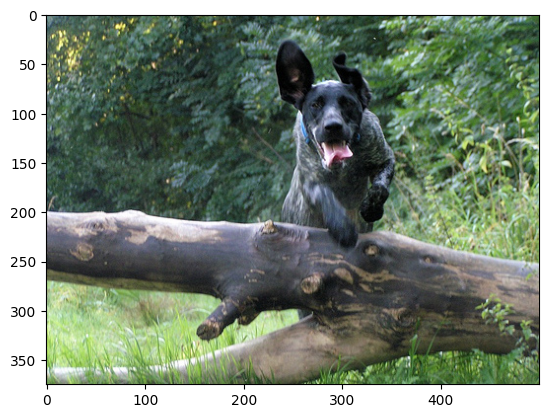

In [88]:
generate_caption('1015584366_dfcec3c85a.jpg')

In [69]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs,
                  outputs=vgg_model.layers[-2].output)

image_path = '/content/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIzLTA4L3Jhd3BpeGVsX29mZmljZV8xNV9waG90b19vZl9hX2RvZ19ydW5uaW5nX3dpdGhfb3duZXJfYXRfcGFya19lcF9mM2I3MDQyZC0zNWJlLTRlMTQtOGZhNy1kY2Q2OWQ1YzQzZjlfMi5qcGc.webp'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image from vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
caption_prediction(trained_model, feature, tokenizer, max_length)

'start white dog is running on the sidewalk end'

In [ ]:
def preprocess_images_real(model, images_path, images_list):
  features={}
  for img_name in tqdm(os.listdir(path)):
     img_path= path+'/'+ img_name# load image
     image = load_img(image_path, target_size=(224, 224))
     # convert image pixels to numpy array
     image = img_to_array(image)
     # reshape data for model
     image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
     # preprocess image from vgg
     image = preprocess_input(image)
     # extract features
     image_id=img_name.split('.')[0]
     feature = feature_extractor.predict(image, verbose=0)
     features[image_id]=feature
  return features

In [ ]:
def generate_captions_real(model,image_name,image_list):
     captions={}
     for img_name in tqdm(os.listdir(image_list)):
         image_id=img_name.split('.')[0]
         caption=caption_prediction(model, loaded_features[image_id], tokenizer, max_length)
         captions[image_id]=caption

     return captions